In [1]:
%load_ext autoreload
%autoreload 2

0) Install/Imports (si besoin)

In [2]:
# !pip install timm==1.0.8 albumentations==1.4.8 opencv-python==4.10.0.84
import os, re, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

1) Utils & parsing des labels

In [3]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".JPG", ".PNG", ".JPEG"}
import re
from pathlib import Path

# Regex : id + "_" + Y(1-2 chiffres) + sexe(M/F) + age(2 chiffres)
_AGE_RE = re.compile(r'^(?P<pid>\d+)_(?P<idx>\d{1,2})(?P<sex>[MF])(?P<age>\d{2})$')

def parse_from_filename(fname: str):
    """
    fname: nom de fichier avec extension (ex: '0007_04M17.JPG')
    return: dict {person_id:int, photo_idx:int, sex:int(M=1,F=0), age:int}
    """
    stem = Path(fname).stem  # retire l'extension
    m = _AGE_RE.match(stem)
    if not m:
        raise ValueError(f"Nom de fichier non conforme: {fname}")
    d = m.groupdict()
    return {
        "person_id": int(d["pid"]),
        "photo_idx": int(d["idx"]),
        "sex": 1 if d["sex"] == "M" else 0,
        "age": int(d["age"]),
    }


In [4]:
parse_from_filename('0007_04M17.JPG')

{'person_id': 7, 'photo_idx': 4, 'sex': 1, 'age': 17}

2) Dataset PyTorch

In [5]:
class AgeDataset(Dataset):
    def __init__(self, img_dir, items, transform=None):
        self.img_dir = Path(img_dir)
        self.items = items  # list of dicts: {"path": str, "age": int, "sex": 0/1}
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        it = self.items[i]
        path = self.img_dir / it["path"]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        age = torch.tensor([it["age"]], dtype=torch.float32)
        sex = torch.tensor([it["sex"]], dtype=torch.float32)
        return img, age, sex, it["path"]

In [6]:
AgeDataset("data/train", [{"path": "0007_01M16.JPG", "age": 16, "sex": 1}])[0]

(<PIL.Image.Image image mode=RGB size=180x180>,
 tensor([16.]),
 tensor([1.]),
 '0007_01M16.JPG')

3) Transforms (train/val/test)

In [7]:
mean, std = [0.485,0.456,0.406], [0.229,0.224,0.225]

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.25)
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


4) Préparation des listes d’images

In [8]:
train_dir = "data/train"
test_dir  = "data/test"

train_items = []
for p in sorted(os.listdir(train_dir)):
    if Path(p).suffix.lower() in IMG_EXTS:
        meta = parse_from_filename(p)
        train_items.append({"path": p, "age": meta["age"], "sex": meta["sex"]})

test_items = [{"path": p} for p in sorted(os.listdir(test_dir)) if Path(p).suffix.lower() in IMG_EXTS]

# Stratification par (bucket_age, sex)
def age_bucket(a, width=5):
    return a // width

y_strat = [f"{age_bucket(x['age'])}_{x['sex']}" for x in train_items]


In [9]:
train_items[:6]

[{'path': '00013_00M19.JPG', 'age': 19, 'sex': 1},
 {'path': '00013_01M19.JPG', 'age': 19, 'sex': 1},
 {'path': '00013_02M19.JPG', 'age': 19, 'sex': 1},
 {'path': '00022_03M19.JPG', 'age': 19, 'sex': 1},
 {'path': '00022_04M20.JPG', 'age': 20, 'sex': 1},
 {'path': '00027_00M30.JPG', 'age': 30, 'sex': 1}]

In [10]:
test_items[:6]

[{'path': '0.JPG'},
 {'path': '1.JPG'},
 {'path': '10.JPG'},
 {'path': '100.JPG'},
 {'path': '101.JPG'},
 {'path': '102.JPG'}]

5) Modèle (backbone timm + tête)

In [11]:
class AgeRegressor(nn.Module):
    def __init__(self, backbone_name="convnext_tiny", use_sex=True):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool="avg")
        feat_dim = self.backbone.num_features
        self.use_sex = use_sex
        in_dim = feat_dim + (1 if use_sex else 0)
        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_dim, 1)
        )
        # self.head = nn.Sequential(
        #     nn.Linear(in_dim, 1024),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(1024, 512),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(512, max_age+1)
        # )


    def forward(self, x, sex=None):
        f = self.backbone(x)  # (B, feat_dim)
        if self.use_sex and sex is not None:
            f = torch.cat([f, sex], dim=1)
        out = self.head(f)  # (B, 1)
        return out


In [12]:
import torch
import torch.nn as nn
import timm

class AgeClassifier(nn.Module):
    def __init__(self, backbone_name="convnext_tiny", max_age=100, use_sex=True, hidden_dim=512):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool="avg")
        feat_dim = self.backbone.num_features
        self.use_sex = use_sex
        in_dim = feat_dim + (1 if use_sex else 0)

        # tu peux augmenter la profondeur du "head"
        self.head = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, max_age+1)  # classes 0..max_age
        )

    def forward(self, x, sex=None):
        f = self.backbone(x)
        if self.use_sex and sex is not None:
            f = torch.cat([f, sex], dim=1)
        logits = self.head(f)         # (B, 101)
        probs = torch.softmax(logits, dim=1)
        return logits, probs


6) Entraînement (1 split ou k-fold)

    6.1. boucle d’entraînement simple

In [13]:
from torch.amp import autocast
def train_one_epoch(model, loader, optim, scaler, device, criterion, max_grad_norm=1.0):
    model.train()
    loss_sum, n = 0.0, 0
    for imgs, ages, sex, _ in loader:
        imgs, ages, sex = imgs.to(device), ages.to(device), sex.to(device)
        optim.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", dtype=torch.float16):
            preds = model(imgs, sex)
            loss = criterion(preds, ages)
        scaler.scale(loss).backward()
        scaler.unscale_(optim)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optim)
        scaler.update()
        bs = imgs.size(0)
        loss_sum += loss.item() * bs
        n += bs
    return loss_sum / n

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    mae_sum, mse_sum, n = 0.0, 0.0, 0
    y_true, y_pred = [], []
    for imgs, ages, sex, _ in loader:
        imgs, ages, sex = imgs.to(device), ages.to(device), sex.to(device)
        preds = model(imgs, sex)
        preds = preds.clamp(0, 100)  # bornes raisonnables
        err = torch.abs(preds - ages)
        mae_sum += err.sum().item()
        mse_sum += ((preds - ages)**2).sum().item()
        n += imgs.size(0)
        y_true.extend(ages.squeeze(1).cpu().numpy().tolist())
        y_pred.extend(preds.squeeze(1).cpu().numpy().tolist())
    mae = mae_sum / n
    rmse = math.sqrt(mse_sum / n)
    # %Within-k
    def within_k(k):
        return (np.mean(np.abs(np.array(y_pred)-np.array(y_true)) <= k) * 100.0)
    metrics = {
        "MAE": mae, "RMSE": rmse,
        "Within_1(%)": within_k(1),
        "Within_2(%)": within_k(2),
        "Within_3(%)": within_k(3),
    }
    # métriques “classification tolérante” (±2 ans)
    y_ok_true = np.ones_like(y_true)  # on évalue seulement “correct/incorrect”
    y_ok_pred = (np.abs(np.array(y_pred)-np.array(y_true)) <= 2).astype(int)
    P = precision_score(y_ok_true, y_ok_pred)
    R = recall_score(y_ok_true, y_ok_pred)
    F1 = f1_score(y_ok_true, y_ok_pred)
    metrics.update({"Prec_tol±2": P, "Rec_tol±2": R, "F1_tol±2": F1})
    return metrics, (y_true, y_pred)


    6.2. entraînement principal

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
# %pip install --index-url https://download.pytorch.org/whl/cu124 torch torchvision torchaudio

In [16]:
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
EPOCHS = 15
LR = 3e-4
WD = 1e-4

# split simple 80/20
idx = np.arange(len(train_items))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(iter(skf.split(idx, y_strat)))

train_list = [train_items[i] for i in train_idx]
val_list   = [train_items[i] for i in val_idx]

train_ds = AgeDataset(train_dir, train_list, transform=train_tf)
val_ds   = AgeDataset(train_dir, val_list, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

model = AgeRegressor("convnext_tiny", use_sex=True).to(device)
criterion = nn.SmoothL1Loss(beta=1.0)  # Huber
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scaler = torch.amp.GradScaler()

best_mae, best_path = 1e9, "best_model.pt"
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss = train_one_epoch(model, train_loader, optimizer, scaler, device, criterion)
    metrics, _ = evaluate(model, val_loader, device)
    dt = time.time()-t0
    print(f"[{epoch}] temps={dt:.1f}s | MAE={metrics['MAE']:.3f}")
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | "
          f"MAE={metrics['MAE']:.3f} | RMSE={metrics['RMSE']:.3f} | "
          f"W2={metrics['Within_2(%)']:.1f}% | F1tol2={metrics['F1_tol±2']:.3f}")
    if metrics["MAE"] < best_mae:
        best_mae = metrics["MAE"]
        torch.save(model.state_dict(), best_path)
 
print("Best MAE:", best_mae, "saved:", best_path)


c:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[1] temps=7712.6s | MAE=4.361
Epoch 01 | train_loss=6.3055 | MAE=4.361 | RMSE=5.608 | W2=29.5% | F1tol2=0.456
[2] temps=2675.9s | MAE=5.025
Epoch 02 | train_loss=3.6624 | MAE=5.025 | RMSE=6.589 | W2=30.3% | F1tol2=0.465
[3] temps=2351.1s | MAE=3.238
Epoch 03 | train_loss=3.2495 | MAE=3.238 | RMSE=4.292 | W2=41.8% | F1tol2=0.589
[4] temps=2324.2s | MAE=3.264
Epoch 04 | train_loss=2.9837 | MAE=3.264 | RMSE=4.297 | W2=41.2% | F1tol2=0.584
[5] temps=2355.2s | MAE=3.071
Epoch 05 | train_loss=2.8134 | MAE=3.071 | RMSE=4.075 | W2=44.3% | F1tol2=0.614
[6] temps=2431.3s | MAE=2.946
Epoch 06 | train_loss=2.7001 | MAE=2.946 | RMSE=3.812 | W2=43.0% | F1tol2=0.601
[7] temps=2543.7s | MAE=2.953
Epoch 07 | train_loss=2.5919 | MAE=2.953 | RMSE=3.841 | W2=42.9% | F1tol2=0.600
[8] temps=2335.4s | MAE=2.889
Epoch 08 | train_loss=2.5039 | MAE=2.889 | RMSE=3.803 | W2=45.3% | F1tol2=0.623
[9] temps=2324.8s | MAE=2.828
Epoch 09 | train_loss=2.4146 | MAE=2.828 | RMSE=3.707 | W2=45.7% | F1tol2=0.627
[10] temps

In [19]:
perf = pd.DataFrame([
    {"epoch": 1, "temps_s": 7712.6, "train_loss": 6.3055, "mae": 4.361, "rmse": 5.608, "W2": 29.5, "F1tol2": 0.456},
    {"epoch": 2, "temps_s": 2675.9, "train_loss": 3.6624, "mae": 5.025, "rmse": 6.589, "W2": 30.3, "F1tol2": 0.465},
    {"epoch": 3, "temps_s": 2351.1, "train_loss": 3.2495, "mae": 3.238, "rmse": 4.292, "W2": 41.8, "F1tol2": 0.589},
    {"epoch": 4, "temps_s": 2324.2, "train_loss": 2.9837, "mae": 3.264, "rmse": 4.297, "W2": 41.2, "F1tol2": 0.584},
    {"epoch": 5, "temps_s": 2355.2, "train_loss": 2.8134, "mae": 3.071, "rmse": 4.075, "W2": 44.3, "F1tol2": 0.614},
    {"epoch": 6, "temps_s": 2431.3, "train_loss": 2.7001, "mae": 2.946, "rmse": 3.812, "W2": 43.0, "F1tol2": 0.601},
    {"epoch": 7, "temps_s": 2543.7, "train_loss": 2.5919, "mae": 2.953, "rmse": 3.841, "W2": 42.9, "F1tol2": 0.600},
    {"epoch": 8, "temps_s": 2335.4, "train_loss": 2.5039, "mae": 2.889, "rmse": 3.803, "W2": 45.3, "F1tol2": 0.623},
    {"epoch": 9, "temps_s": 2324.8, "train_loss": 2.4146, "mae": 2.828, "rmse": 3.707, "W2": 45.7, "F1tol2": 0.627},
    {"epoch": 10, "temps_s": 2368.5, "train_loss": 2.3695, "mae": 2.784, "rmse": 3.673, "W2": 46.2, "F1tol2": 0.632},
    {"epoch": 11, "temps_s": 2312.4, "train_loss": 2.2849, "mae": 2.770, "rmse": 3.614, "W2": 46.8, "F1tol2": 0.637},
    {"epoch": 12, "temps_s": 2346.4, "train_loss": 2.2405, "mae": 2.938, "rmse": 3.742, "W2": 41.9, "F1tol2": 0.590},
    {"epoch": 13, "temps_s": 3032.2, "train_loss": 2.1591, "mae": 2.942, "rmse": 3.799, "W2": 43.0, "F1tol2": 0.601},
    {"epoch": 14, "temps_s": 2599.9, "train_loss": 2.1122, "mae": 2.790, "rmse": 3.624, "W2": 45.3, "F1tol2": 0.623},
    {"epoch": 15, "temps_s": 2.0572, "train_loss": 2.1122, "mae": 2.684 , "rmse": 3.534, "W2": 48.0, "F1tol2": 0.649}
])
perf

,epoch,temps_s,train_loss,mae,rmse,W2,F1tol2
0,1,7712.6000,6.3055,4.361,5.608,29.5,0.456
1,2,2675.9000,3.6624,5.025,6.589,30.3,0.465
2,3,2351.1000,3.2495,3.238,4.292,41.8,0.589
3,4,2324.2000,2.9837,3.264,4.297,41.2,0.584
4,5,2355.2000,2.8134,3.071,4.075,44.3,0.614
5,6,2431.3000,2.7001,2.946,3.812,43.0,0.601
6,7,2543.7000,2.5919,2.953,3.841,42.9,0.600
7,8,2335.4000,2.5039,2.889,3.803,45.3,0.623
8,9,2324.8000,2.4146,2.828,3.707,45.7,0.627
9,10,2368.5000,2.3695,2.784,3.673,46.2,0.632


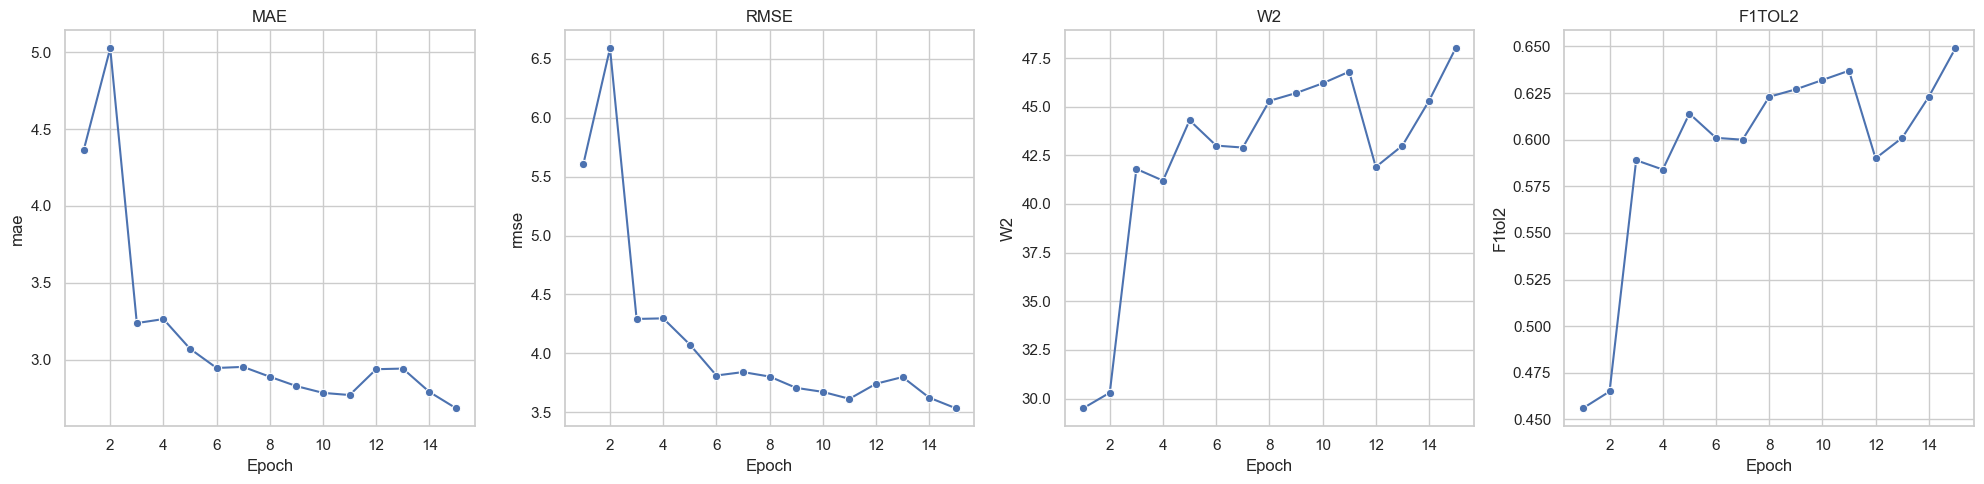

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style seaborn
sns.set(style="whitegrid")

# Liste des métriques à tracer
metrics = ["train_loss", "mae", "rmse", "W2", "F1tol2"]

# Créer une figure avec 4 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharex=True)

for ax, metric in zip(axes, metrics):
    sns.lineplot(data=perf, x="epoch", y=metric, marker="o", ax=ax)
    ax.set_title(metric.upper())
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

7) Inférence sur le test + export CSV/JSON

In [17]:
# charge meilleurs poids
model = AgeRegressor("convnext_tiny", use_sex=True).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

test_tf = val_tf  # pas d'augmentation forte à test
class TestDataset(Dataset):
    def __init__(self, img_dir, items, transform=None):
        self.img_dir = Path(img_dir); self.items = items; self.transform = transform
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        p = self.items[i]["path"]
        img = Image.open(self.img_dir / p).convert("RGB")
        if self.transform: img = self.transform(img)
        # sexe inconnu en test → on met 0.5 (neutre) ou 0 si non utilisé
        sex = torch.tensor([0.5], dtype=torch.float32)
        return img, sex, p

test_ds = TestDataset(test_dir, test_items, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

preds, names = [], []
with torch.no_grad():
    for imgs, sex, ps in test_loader:
        imgs, sex = imgs.to(device), sex.to(device)
        y = model(imgs, sex).clamp(0, 100)
        preds.extend(y.squeeze(1).cpu().numpy().tolist())
        names.extend(ps)

# si besoin d’entiers:
preds_int = [int(round(x)) for x in preds]

# Format d’export recommandé:
# CSV avec colonnes: filename, age
sub_df = pd.DataFrame({"filename": names, "age": preds_int})
sub_df.to_csv("submission_age.csv", index=False)

# JSON possible
sub_df.to_json("submission_age.json", orient="records", lines=False)
print(sub_df.head())


  filename  age
0    0.JPG   18
1    1.JPG   24
2   10.JPG   31
3  100.JPG   33
4  101.JPG   31


1) Évaluation robustesse 

In [18]:
from torchvision.transforms.functional import adjust_brightness
@torch.no_grad()
def eval_brightness(model, loader, device, factor=1.5):
    model.eval()
    mae_sum, n = 0.0, 0
    for imgs, ages, sex, _ in loader:
        imgs_b = torch.stack([adjust_brightness(img, factor) for img in imgs])
        imgs_b, ages, sex = imgs_b.to(device), ages.to(device), sex.to(device)
        y = model(imgs_b, sex).clamp(0,100)
        mae_sum += torch.abs(y-ages).sum().item()
        n += imgs.size(0)
    return mae_sum/n

b_mae = eval_brightness(model, val_loader, device, factor=1.5)
print("MAE sous bright+50%:", round(b_mae,3))


MAE sous bright+50%: 6.458


Le modèle 15 manque de robustesse. Essayons avec le 11

In [24]:
model_11 = AgeRegressor("convnext_tiny", use_sex=True).to(device)
model_11.load_state_dict(torch.load("outputs/models/best_model_11.pt", map_location=device))
model_11.eval()

b_mae = eval_brightness(model_11, val_loader, device, factor=1.5)
print("MAE sous bright+50%:", round(b_mae,3))


MAE sous bright+50%: 6.795


pire

---

> ## 🔎 Lecture des métriques
>
> Le modèle à l'époch 15 semble la meilleur, vu que le MAE a commencé à diverger
> 
>* **MAE (Mean Absolute Error) ≈ 8.8 ans**
>  → En moyenne, ton modèle se trompe de \~9 ans.
>  Pour une tâche d’estimation d’âge, c’est **correct** si ton dataset couvre 0–100 ans, mais ce n’est pas encore “très bon”.
>  (En recherche, des modèles sur gros datasets arrivent plutôt entre 3–5 ans de MAE, mais avec beaucoup plus de données et souvent du pré-entrainement spécifique au visage.)
>
>* **RMSE ≈ 10.5 ans**
>  → Les grosses erreurs pèsent plus (carré). Ton modèle fait parfois des erreurs bien plus grandes que 9 ans.
>
>* **Within 2 ans (W2) = 12.7%**
>  → Seulement 12.7% des prédictions sont à ±2 ans de l’âge réel.
>  C’est assez faible. Sur des modèles plus spécialisés visage, on viserait plutôt 30–40% ou plus.
>
>* **F1 tol ±2 = 0.225**
>  → C’est cohérent avec W2 : ton rappel et ta précision dans cette tolérance restent faibles.
>
>* **Temps par époque**
>
>  * Epoch 1 : 1967 s (≈ 33 min) → probablement DataLoader lent au démarrage.
>  * Epoch 2 : 2377 s (≈ 40 min).
>  * Epoch 3 : 916 s (≈ 15 min).
>
> ## ⚖️ Interprétion
>
>* Ton modèle **apprend bien** (MAE passe de 9.58 → 8.79 en 3 époques).
>* **Mais la performance reste moyenne** (erreur \~9 ans).
>* Le temps par époque est **élevé** mais acceptable pour ce volume (\~40k images).
>
>## 🚀 Pistes d’amélioration
>
>1. **Modèle (backbone)**
>
>   * On a testé `convnext_tiny`.
>   * Essayer `resnet50`, `efficientnet_b3`, ou même `swin_tiny` via `timm` : certains sont meilleurs sur visages.
>
>2. **Formulation de la tâche**
>
>   * On es en **régression directe** → souvent moins robuste.
>   * Essayer la **classification douce (0–100 ans, soft labels)** : ça stabilise et améliore généralement MAE et W2.
>
>3. **Data augmentation**
>
>   * Améliorer la robustesse : flips, légère rotation, color jitter.
>   * On avait mis RandomErasing : ça peut être violent sur des visages → à tester prudemment.
>
>4. **Entraînement plus long**
>
>   * Avec seulement 3 époques, on n’a pas encore convergé.
>   * Tester 15–20 époques (en surveillant MAE val).
>
>5. **Batch normalization et dropout**
>
>   * Vérifier si on a assez de régularisation.
>   * Un head un peu plus profond (2–3 couches) peut aider.
>
>**Conclusion**
>
> *“Après 3 époques, notre modèle ConvNeXt Tiny atteint une MAE de \~8.8 ans. Cela montre que le modèle apprend (MAE en baisse), mais les performances restent moyennes : seule \~12% des prédictions sont dans une tolérance de ±2 ans. Il y a encore une marge d’amélioration, notamment en testant la formulation classification douce, un backbone plus puissant (EfficientNet/ResNet50), et un entraînement plus long (10–20 époques).”*
